# Baseline Model Plain PyTorch

In this notebook I train a Segmentation model using plain PyTorch code. The goal is to compare how much code is needed to accomplish what Lightning offers.

There are no changes to the data, preprocessing and/or model

In [1]:
from recognizer.utils. constants import DATA_DIR, ROOT_DIR

IMAGES_DIR = DATA_DIR / "preprocessed-10p" / "images"
MASKS_DIR = DATA_DIR / "preprocessed-10p" / "masks"
CHECKPOINTS_DIR = ROOT_DIR / "checkpoints"

In [2]:
from dotenv import load_dotenv

load_dotenv(ROOT_DIR / ".env")

True

In [3]:
import os

image_to_mask_map = dict()

for img_file in os.listdir(IMAGES_DIR):
    image_to_mask_map[img_file] = img_file.replace("image", "mask")


In [4]:
image_filenames = list(image_to_mask_map.keys())
mask_filenames = [image_to_mask_map[image] for image in image_filenames]

In [5]:
from sklearn.model_selection import train_test_split

images_train, images_test, masks_train, masks_test = train_test_split(image_filenames, mask_filenames, test_size=0.1, random_state=180)
images_train, images_val, masks_train, masks_val = train_test_split(images_train, masks_train, test_size=0.1127, random_state=180) # 0.1 * 0.9 = 0.1127

In [6]:
len(images_train), len(images_val), len(images_test)

(408, 52, 52)

In [7]:
import torch

from torchvision.transforms import v2

image_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

mask_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32),
])

In [8]:
from recognizer.datasets import SegmentationDataset

train_dataset = SegmentationDataset(
    images_dir=str(IMAGES_DIR),
    masks_dir=str(MASKS_DIR),
    image_files=images_train,
    mask_files=masks_train,
    transform=image_transform,
    target_transform=mask_transform
)

val_dataset = SegmentationDataset(
    images_dir=str(IMAGES_DIR),
    masks_dir=str(MASKS_DIR),
    image_files=images_val,
    mask_files=masks_val,
    transform=image_transform,
    target_transform=mask_transform
)

test_dataset = SegmentationDataset(
    images_dir=str(IMAGES_DIR),
    masks_dir=str(MASKS_DIR),
    image_files=images_test,
    mask_files=masks_test,
    transform=image_transform,
    target_transform=mask_transform
)

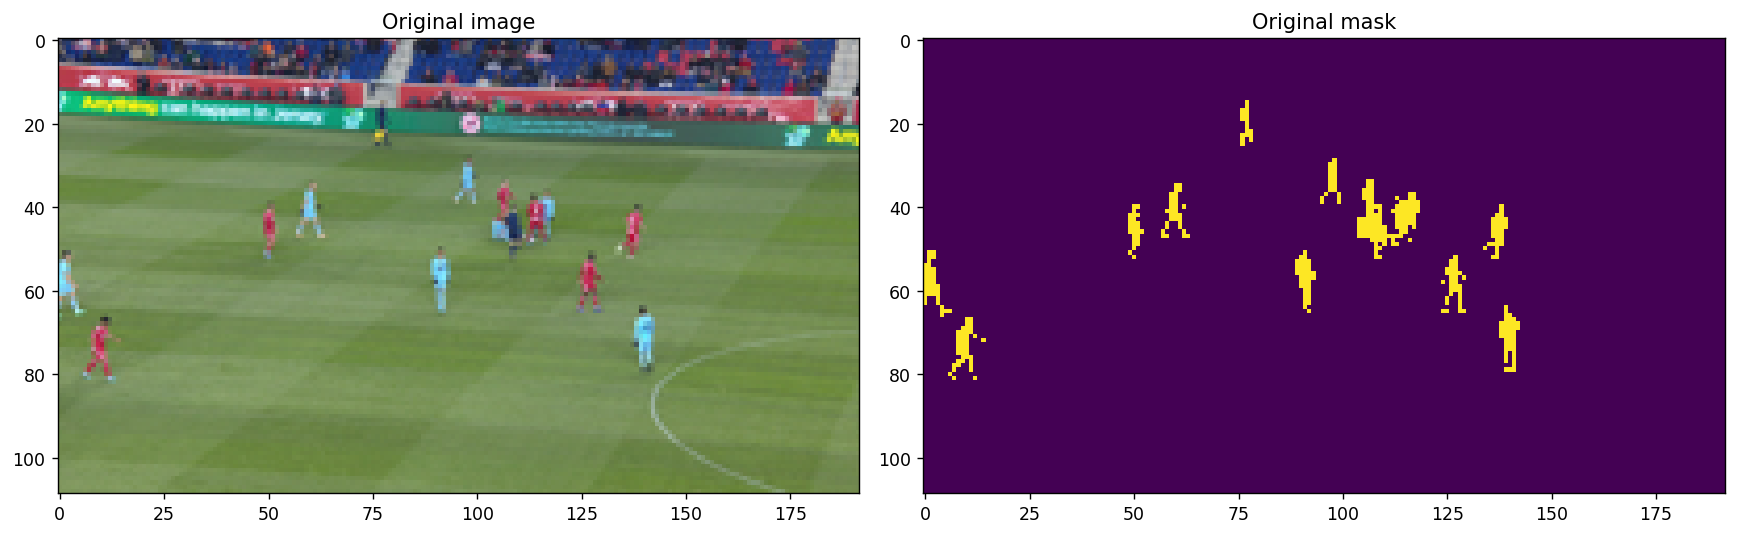

In [9]:
import numpy as np
import matplotlib.pyplot as plt

X = test_dataset[int(np.random.random()*len(test_dataset))]

image = X[0].unsqueeze(0)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 8), dpi=125)

axs[0].set_title("Original image")
axs[0].imshow(X[0].permute(1, 2, 0))

axs[1].set_title("Original mask")
axs[1].imshow(X[1].permute(1, 2, 0))

plt.tight_layout()

## Parameters

In [10]:
BATCH_SIZE = 8
EPOCHS = 30
LR = 1e-4
ES_PATIENCE = 3
ES_DELTA = 0.01

In [11]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False, num_workers=4, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4, pin_memory=True, persistent_workers=True)

In [12]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [34]:
from recognizer.models.unet import UNet
from torch import nn
from torchmetrics.classification import BinaryJaccardIndex, Dice

model = UNet(n_channels=3, n_classes=1)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_function = nn.BCEWithLogitsLoss()

dice_metric = Dice(average='micro', num_classes=2, ignore_index=True).to(device)
jaccard_metric = BinaryJaccardIndex().to(device)

In [35]:
from mlflow.models import infer_signature

dummy_input = torch.randn(BATCH_SIZE, 3, 108, 192).to(device)

output = model(dummy_input)

print("Output shape:", output.shape)  # Should be [BATCH_SIZE, 1, 108, 192]

signature = infer_signature(dummy_input.cpu().numpy(), output.detach().cpu().numpy())

Output shape: torch.Size([8, 1, 108, 192])


In [36]:
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {p}")

Params: 17267393


In [37]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

metrics = {
    "train_loss": [],
    "val_loss": [],
    "val_dice": [],
    "val_iou": [],
}

In [40]:
import mlflow
 
mlflow.set_experiment("Football Players Segmentation")
mlflow.pytorch.autolog(registered_model_name =True)

EPOCHS = 3
print(f"""
About to train model with parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
- Early Stopping patience: {ES_PATIENCE}
- Early Stopping delta: {ES_DELTA}
""")

with mlflow.start_run(run_name="UNet - Plain PyTorch", log_system_metrics=True) as run:

    best_loss = np.inf
    epochs_without_improvement = 0
    validate_every_n_epochs = 1

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1} - Train")

        model.train()

        running_train_loss = 0.0

        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)

            output = model(inputs)

            loss = loss_function(output, labels)

            running_train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        average_training_loss = running_train_loss / len(train_loader)

        metrics["train_loss"].append(round(average_training_loss, 2))

        print(f"Training Loss: {average_training_loss:.2f}")

        # Validation loop
        if (epoch + 1) % validate_every_n_epochs == 0:
            print(f"Epoch {epoch + 1} - Validation")

            dice_metric.reset()
            jaccard_metric.reset()

            all_preds = []
            all_targets = []

            model.eval()
            val_loss = 0.0
            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    y_pred = model(inputs)

                    val_loss += loss_function(y_pred, labels).item()

                    preds = y_pred.argmax(dim=1).int()  # Shape: (batch_size, height, width)
                    labels = labels.int()

                    if labels.dim() == 4:
                        labels = labels.squeeze(1)

                    dice_metric.update(preds, labels)
                    jaccard_metric.update(preds, labels)

            val_loss = val_loss / len(val_loader)

            dice_score = dice_metric.compute()
            jaccard_score = jaccard_metric.compute()

            metrics["val_loss"].append(round(val_loss, 2))
            metrics["val_dice"].append(round(dice_score.item(), 4))
            metrics["val_iou"].append(round(jaccard_score.item(), 4))

            dice_metric.reset()
            jaccard_metric.reset()

            print(f"Validation Loss: {val_loss:.4f}")

            for metric in metrics.keys():
                mlflow.log_metric(
                    key=metric,
                    value=metrics[metric][-1],
                    step=epoch,
                )
            
            mlflow.pytorch.log_model(pytorch_model=model, artifact_path="model", signature=signature)

            if val_loss < best_loss - ES_DELTA:
                best_loss = val_loss
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1
            
            if epochs_without_improvement >= ES_PATIENCE:
                print(f"Early stopping triggered. Validation loss is not improving!")
                break

2024/06/23 16:09:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2024/06/23 16:09:35 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.



About to train model with parameters:
- Epochs: 3
- Batch Size: 8
- Early Stopping patience: 3
- Early Stopping delta: 0.01

Epoch 1 - Train
Training Loss: 0.23
Epoch 1 - Validation
Validation Loss: 0.2276


2024/06/23 16:24:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.2.2+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.2.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/06/23 16:25:14 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2024/06/23 16:25:14 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


KeyboardInterrupt: 

# Testing

## Inference

In [39]:
raise Exception

Exception: 

In [ ]:
checkpoint_callback.best_model_path

In [ ]:
checkpoint_callback.best_k_models

In [ ]:
best_model = LitSegmenter.load_from_checkpoint(checkpoint_callback.best_model_path, map_location=torch.device("cpu"))

In [ ]:
path_to_first_model = "C:\\Users\\facun\\Desktop\\DEV\\torch-lightning-playground\\checkpoints\\lightning_logs\\version_3\\checkpoints\\epoch=5-step=306.ckpt"

first_model = LitSegmenter.load_from_checkpoint(path_to_first_model, map_location=torch.device("cpu"))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X = test_dataset[int(np.random.random()*len(test_dataset))]

image = X[0].unsqueeze(0)

with torch.inference_mode():
    y_pred = best_model(image)
    y_pred_first = first_model(image)


In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(14, 8), dpi=125)

axs[0].set_title("Image")
axs[0].imshow(X[0].permute(1, 2, 0))

axs[1].set_title("Original mask")
axs[1].imshow(X[1].permute(1, 2, 0))

axs[2].set_title("Predicted mask (best model)")   
axs[2].imshow(y_pred.squeeze(0).permute(1, 2, 0))

axs[3].set_title("Predicted mask (first model)")
axs[3].imshow(y_pred_first.squeeze(0).permute(1, 2, 0))

plt.tight_layout()